ah5647
Alon Hillel-Tuch

#### NOTE TO GRADER

Observations and discussions related to step 6 are included throughout the notebook. This includes discussion on Step 6 and  step 7, with a larger review at the end of the notebook. Thanks!

In [1]:
# Imports
import numpy as np
import pandas as pd

from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import graphviz

import math

from collections import Counter
from sklearn.datasets import make_classification
from imblearn.under_sampling import RandomUnderSampler 
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

from seaborn import heatmap

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.linear_model import ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR

### STEP 1: Importing the dataset

In [2]:
# Reading Data (we have it stored as a local file) and create our column names.
#This data is not in csv format, but instead a space delimited text file, so we are going to import it as such.
# We use the attribute information to store the column header values and assign it to our dataframe

names_ = ['CRIM','ZN','INDUS','CHAS','NOX','RM','AGE','DIS','RAD','TAX','PTRATIO','B','LSTAT','MEDV']

df = pd.read_csv('../Week 8/housing.data', delim_whitespace=True,header=None,names=names_)


In [3]:
# Analyzing data set
print("Number of Samples: ", df.shape[0])
print("Number of features: ", df.shape[1])

Number of Samples:  506
Number of features:  14


In [4]:
#sanity check
df.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222.0,18.7,396.90,5.33,36.2


In [5]:
#Notes: lstat is a percentage, rad is most likely ordinal. For doing our initial correlation analysis, 
#we can simply normalize this information, however, we should keep an eye it if we need to further pre-process.

In [6]:
#in order to easily plot, we are going to normalize the data (we are leaving normalize attribute as false in our models)
import pandas as pd
from sklearn import preprocessing

x = df.values #returns a numpy array
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)

#storing as df2 so we can always access df for models such as decision tree
df2 = pd.DataFrame(x_scaled)
df2.columns = names_
df2.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.000000,0.18,0.067815,0.0,0.314815,0.577505,0.641607,0.269203,0.000000,0.208015,0.287234,1.000000,0.089680,0.422222
1,0.000236,0.00,0.242302,0.0,0.172840,0.547998,0.782698,0.348962,0.043478,0.104962,0.553191,1.000000,0.204470,0.368889
2,0.000236,0.00,0.242302,0.0,0.172840,0.694386,0.599382,0.348962,0.043478,0.104962,0.553191,0.989737,0.063466,0.660000
3,0.000293,0.00,0.063050,0.0,0.150206,0.658555,0.441813,0.448545,0.086957,0.066794,0.648936,0.994276,0.033389,0.631111
4,0.000705,0.00,0.063050,0.0,0.150206,0.687105,0.528321,0.448545,0.086957,0.066794,0.648936,1.000000,0.099338,0.693333


### STEP 2: Selecting Features we believe may be correlated

**CRIM and MEDV (threshold)-**
One thing we know is that crime rates (CRIM) directly influence property values (MEDV), a frequently studied occurence. However, we may need qualify further due to dense urban environments, the per capita value may go down while gross number of crimes are higher. I actually suspect it is not-linearly correlated, but there may be a strong inverse threshold, when crime is low, home prices are high, but when crime even slightly increases home prices will drop. I suspect what we will see is a concentration across all MEDV homes to be below a certain crime threshold. So a benefit here would be to remove outliers (noise) if fine tuning further.  

**RM, LSTAT, and MEDV-**
We can also assume that as the number of rooms increase (RM) we see (MEDV) increase as well. We interpret LSTAT to mean low-income population, typically we would expect this to be quite strongly correlated. That is we will see RM-MEDV and LSTAT-MEDV correlated. 

**TAX,NOX, INDUS-**
Another potentially strong correlation is TAX and INDUS as well as NOX and INDUS. INDUS looks at non-retail businesses, which would imply (typically) industry. The more industry the more nitric oxide we may expect, as well as tax rate on property. As the property tax is not exclusive to residential, but inclusive of all property types.

**NOX, DIS, AGE-**
Typically the older a certain unit has been built the more likely there were unsound environmental considerations made. More importantly, when thinking about urbanization, often homes used to be built near factories and over time as the factories expanded the homes became surrounded by heavy industry. As time progressed and society became more aware of environmental considerations new homes were build in designated residential zones which were more segregated from environmental exposure. This means, that perhaps as AGE goes up, we may expect NOX to increase as well. Under that same argument, we may expect to see a inverse correlation between DIS and AGE, Since often older homes were the catalyst to the development of a city center. As such, the closer (lower) DIS is, the older (higher) AGE is. 

**Suspected highest correlation: TAX, RAD-** Universally the closer a property is located near a highway the higher valued the property tends to be. We have observed entire developments shift due to highway formation. This includes the abandonment of towns that are further away from a highway, towards a town that is closer to a 'new' highway. For industry and commercial, a highway implies access to transportation. All across, a highway almost always should imply a higher tax value. 

**RM, CRIM, LSTAT as related to MEDV**

In [7]:
#Feature selection
selection_ = ['MEDV','RM','LSTAT','CRIM']
df_feat = df2[selection_]
df_feat.columns = selection_
print("Number of Samples: ", df_feat.shape[0])
print("Number of features: ", df_feat.shape[1])


Number of Samples:  506
Number of features:  4


In [8]:
df_feat.head()

,MEDV,RM,LSTAT,CRIM
0,0.422222,0.577505,0.089680,0.000000
1,0.368889,0.547998,0.204470,0.000236
2,0.660000,0.694386,0.063466,0.000236
3,0.631111,0.658555,0.033389,0.000293
4,0.693333,0.687105,0.099338,0.000705


Below is a visualization of our selections from above. Keep in mind, we are just using a very simple regression model (standard model) to fit the line, this is more to demonstrate what it 'could' look like. When applying our different models we will see differences that are more noticable, such as the gradient of the line and they y-intercept. 

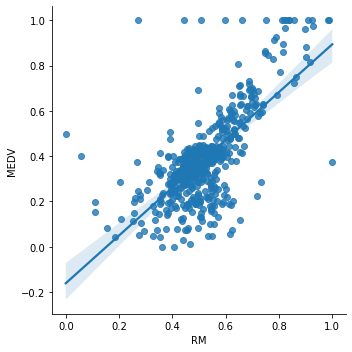

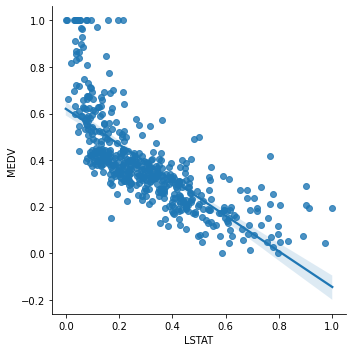

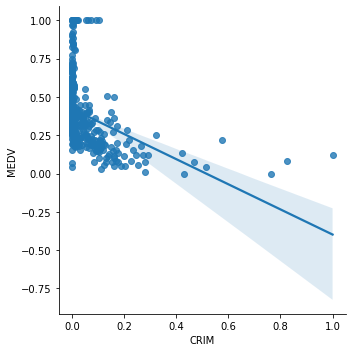

In [9]:
import seaborn as sns
for i in selection_[1:]:
    #sns.scatterplot(x=selection_[0], y=i, data=df_feat);
    sns.lmplot(x=i, y=selection_[0], data=df_feat);


When plotting MEDV and CRIM, we can observe that anticipated 'cut-off' we expected. 

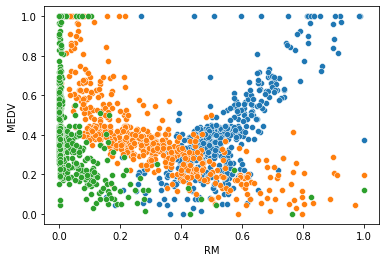

In [10]:
for i in selection_[1:]:
    sns.scatterplot(x=i, y=selection_[0], data=df_feat);

In [ ]:
#Note that the x-axis in the above is not just RM but also all other selected features. The y-axis is MEDV.

In [11]:
#Modified from source: https://www.sfu.ca/~mjbrydon/tutorials/BAinPy/08_correlation.html

from scipy import stats
for i in selection_[1:]:
    print("Correlation between ",selection_[0],"and",i)
    print(stats.pearsonr(df_feat[selection_[0]], df_feat[i]))
#value 1: Pearson’s r
#value 2: A p-value. This is the probability that the true value of r is zero (no correlation).

Correlation between  MEDV and RM
(0.6953599470715394, 2.4872288710071593e-74)
Correlation between  MEDV and LSTAT
(-0.7376627261740147, 5.081103394387547e-88)
Correlation between  MEDV and CRIM
(-0.3883046085868116, 1.1739870821941207e-19)


r = 0 would imply no correlation, r=-1 would indicate an inverse correlation, and r = 1 would indicate a perfect correlation.

We can see that MEDV and RM are correlated, and MEDV and LSTAT are inversely correlated. That is, as LSTAT increases, MEDV decreases. As predicted MEDV and CRIM seem to be threshold based, once CRIM>0.3 there almost no sample that meets. As in, no housing properties willing to exist in a high CRIM range.

**TAX, NOX as related to INDUS**

In [12]:
#Feature selection
selection_ = ['INDUS','TAX','NOX']
df_feat = df2[selection_]
df_feat.columns = selection_
print("Number of Samples: ", df_feat.shape[0])
print("Number of features: ", df_feat.shape[1])


Number of Samples:  506
Number of features:  3


In [13]:
df_feat.head()

,INDUS,TAX,NOX
0,0.067815,0.208015,0.314815
1,0.242302,0.104962,0.172840
2,0.242302,0.104962,0.172840
3,0.063050,0.066794,0.150206
4,0.063050,0.066794,0.150206


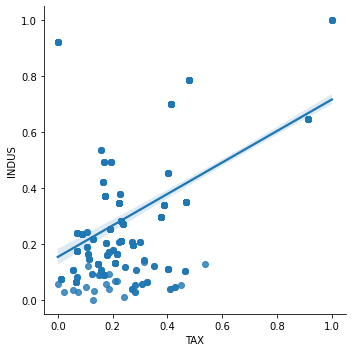

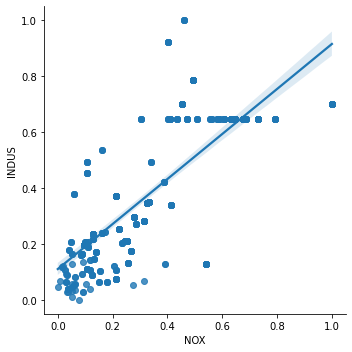

In [14]:
import seaborn as sns
for i in selection_[1:]:
    #sns.scatterplot(x=selection_[0], y=i, data=df_feat);
    sns.lmplot(x=i, y=selection_[0], data=df_feat);


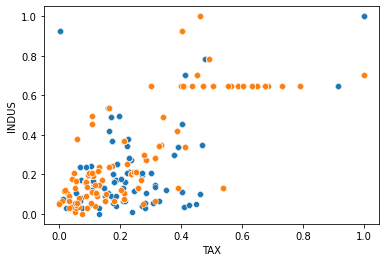

In [15]:
for i in selection_[1:]:
    sns.scatterplot(x=i, y=selection_[0], data=df_feat);

In [ ]:
#Same as before, the x-axis is both TAX and NOX. 

In [16]:
#Modified from source: https://www.sfu.ca/~mjbrydon/tutorials/BAinPy/08_correlation.html

from scipy import stats
for i in selection_[1:]:
    print("Correlation between ",selection_[0],"and",i)
    print(stats.pearsonr(df_feat[selection_[0]], df_feat[i]))
#value 1: Pearson’s r
#value 2: A p-value. This is the probability that the true value of r is zero (no correlation).

Correlation between  INDUS and TAX
(0.7207601799515426, 3.0181993915177473e-82)
Correlation between  INDUS and NOX
(0.7636514469209156, 7.913361061235544e-98)


Both correlations are >0.70 as related to INDUS. We can see that there are two features here that are well correlated with INDUS. I wouldn't say 'strong', which is usually greater than 0.9

**NOX, DIS as related to AGE**

In [17]:
#Feature selection
selection_ = ['AGE','DIS','NOX']
df_feat = df2[selection_]
df_feat.columns = selection_
print("Number of Samples: ", df_feat.shape[0])
print("Number of features: ", df_feat.shape[1])


Number of Samples:  506
Number of features:  3


In [18]:
df_feat.head()

,AGE,DIS,NOX
0,0.641607,0.269203,0.314815
1,0.782698,0.348962,0.172840
2,0.599382,0.348962,0.172840
3,0.441813,0.448545,0.150206
4,0.528321,0.448545,0.150206


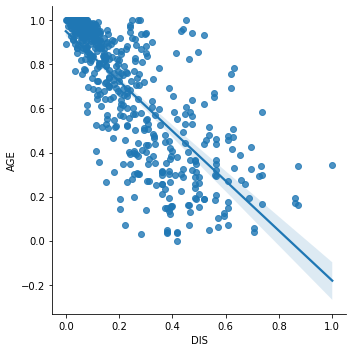

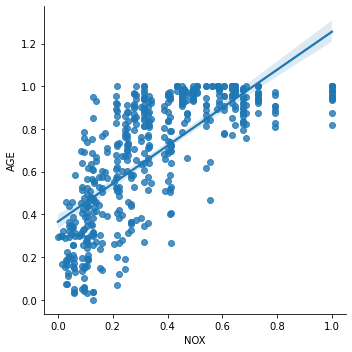

In [19]:
import seaborn as sns
for i in selection_[1:]:
    #sns.scatterplot(x=selection_[0], y=i, data=df_feat);
    sns.lmplot(x=i, y=selection_[0], data=df_feat);


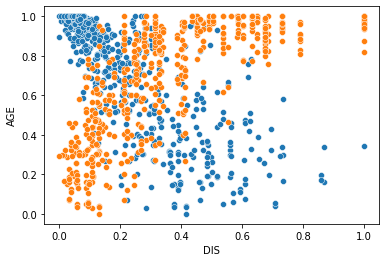

In [20]:
for i in selection_[1:]:
    sns.scatterplot(x=i, y=selection_[0], data=df_feat);

In [ ]:
#x-axis contains both NOX and DIS, y-axis is Age.

In [21]:
#Modified from source: https://www.sfu.ca/~mjbrydon/tutorials/BAinPy/08_correlation.html

from scipy import stats
for i in selection_[1:]:
    print("Correlation between ",selection_[0],"and",i)
    print(stats.pearsonr(df_feat[selection_[0]], df_feat[i]))
#value 1: Pearson’s r
#value 2: A p-value. This is the probability that the true value of r is zero (no correlation).

Correlation between  AGE and DIS
(-0.7478805408686318, 9.857534072928722e-92)
Correlation between  AGE and NOX
(0.7314701037859587, 7.452392170285581e-86)


We can see here again >.70 correlations. In this case AGE and DIS are inversely correlated and AGE and NOX are correlated. This lines up with our initial assumptions.

**TAX and RAD**

In [22]:
#Feature selection
selection_ = ['TAX','RAD']
df_feat = df2[selection_]
df_feat.columns = selection_
print("Number of Samples: ", df_feat.shape[0])
print("Number of features: ", df_feat.shape[1])


Number of Samples:  506
Number of features:  2


In [23]:
df_feat.head()

,TAX,RAD
0,0.208015,0.000000
1,0.104962,0.043478
2,0.104962,0.043478
3,0.066794,0.086957
4,0.066794,0.086957


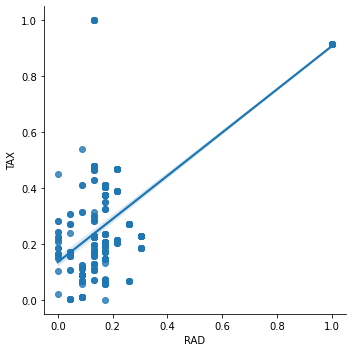

In [24]:
import seaborn as sns
for i in selection_[1:]:
    #sns.scatterplot(x=selection_[0], y=i, data=df_feat);
    sns.lmplot(x=i, y=selection_[0], data=df_feat);


We can see there are a few outliers. However, this is because RAD is a categorical feature. Observing the dataset we see a range of  1 to 24 (before normalization). I suspect RAD is ordinal, with a ranking system that the higher RAD is the poorer accesibility is. As such, while each index is a category in and of itself, their value from an accessibility perspective aligns with a numerical value with a linear relationship of accessibility between 1-24.

In [26]:
#Feature selection
selection_ = ['TAX','RAD']
df_feat = df[selection_]
df_feat.columns = selection_
print("Number of Samples: ", df_feat.shape[0])
print("Number of features: ", df_feat.shape[1])


Number of Samples:  506
Number of features:  2


In [27]:
#Modified from source: https://www.sfu.ca/~mjbrydon/tutorials/BAinPy/08_correlation.html

from scipy import stats
for i in selection_[1:]:
    print("Correlation between ",selection_[0],"and",i)
    print(stats.pearsonr(df_feat[selection_[0]], df_feat[i]))
#value 1: Pearson’s r
#value 2: A p-value. This is the probability that the true value of r is zero (no correlation).

Correlation between  TAX and RAD
(0.9102281885331859, 4.1299201194145705e-195)


As expected, wow, a very strong correlation between TAX and RAD! This is the highest correlation of any features we have reviewed!

### Step 3: Pick one feature that you think can be predicted by the other features in the dataset. 
The feature to be predicted needs to have numerical values.

###### Create a correlation matrix of all features to verify assumptions made in Step 2, and see if we missed anything

In [28]:
#Let's build a correlation matrix
cormat = df2.corr()
round(cormat,2)

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
CRIM,1.00,-0.20,0.41,-0.06,0.42,-0.22,0.35,-0.38,0.63,0.58,0.29,-0.39,0.46,-0.39
ZN,-0.20,1.00,-0.53,-0.04,-0.52,0.31,-0.57,0.66,-0.31,-0.31,-0.39,0.18,-0.41,0.36
INDUS,0.41,-0.53,1.00,0.06,0.76,-0.39,0.64,-0.71,0.60,0.72,0.38,-0.36,0.60,-0.48
CHAS,-0.06,-0.04,0.06,1.00,0.09,0.09,0.09,-0.10,-0.01,-0.04,-0.12,0.05,-0.05,0.18
NOX,0.42,-0.52,0.76,0.09,1.00,-0.30,0.73,-0.77,0.61,0.67,0.19,-0.38,0.59,-0.43
RM,-0.22,0.31,-0.39,0.09,-0.30,1.00,-0.24,0.21,-0.21,-0.29,-0.36,0.13,-0.61,0.70
AGE,0.35,-0.57,0.64,0.09,0.73,-0.24,1.00,-0.75,0.46,0.51,0.26,-0.27,0.60,-0.38
DIS,-0.38,0.66,-0.71,-0.10,-0.77,0.21,-0.75,1.00,-0.49,-0.53,-0.23,0.29,-0.50,0.25
RAD,0.63,-0.31,0.60,-0.01,0.61,-0.21,0.46,-0.49,1.00,0.91,0.46,-0.44,0.49,-0.38
TAX,0.58,-0.31,0.72,-0.04,0.67,-0.29,0.51,-0.53,0.91,1.00,0.46,-0.44,0.54,-0.47


###### Turn into heatmap for easier visualization

<AxesSubplot:>

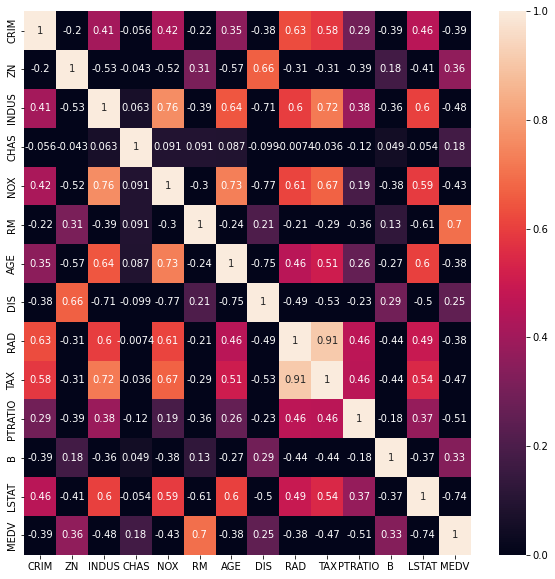

In [29]:
plt.figure(figsize=(10,10))
heatmap(df2.corr(), vmin=0, vmax=1, annot=True, color='Red')

Looking at the correlations mapped out, it appears that either NOX or INDUS are good candidates. **Let's try and predict NOX.**

### Step 4: Separate the data into training, validation, and test sets. 

We have created a simple function to take the feature we selected and easily structure the data for training a model. It returns a dataframe we can use if needed, but it's mainly for diagnostic purposes. 

In [30]:
X = []
y = []
X_train = []
X_test = []
y_train = []
y_test = []
X_val = []
y_val = []

def select_feature(feature):
    global X
    global y
    
    global X_train
    global y_train
    
    global X_test
    global y_test
    
    global X_val
    global y_val
    
    global df
    global df2
    
    df_target = pd.DataFrame(df[feature])   
    # Remember, df2 was normalized. we take feature from original df for our final value.
    df3 = df2.drop(columns=[feature])
    #df2.head()
    scaled_df = pd.concat([df_target, df3], axis=1)
    #scaled_df.head()
    X = scaled_df.values[:,1:] 
    
    #train, val, test 60%,20%,20%
    
    y = scaled_df.values[:,0]
    
    X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=1)
    
    #now split the 80 training set (20 to val) making it 60,20,20
    X_train,X_val,y_train,y_val = train_test_split(X,y,test_size=0.25,random_state=1)
    
    return scaled_df

scaled_df = select_feature('NOX')
scaled_df.head()
    

,NOX,CRIM,ZN,INDUS,CHAS,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.538,0.000000,0.18,0.067815,0.0,0.577505,0.641607,0.269203,0.000000,0.208015,0.287234,1.000000,0.089680,0.422222
1,0.469,0.000236,0.00,0.242302,0.0,0.547998,0.782698,0.348962,0.043478,0.104962,0.553191,1.000000,0.204470,0.368889
2,0.469,0.000236,0.00,0.242302,0.0,0.694386,0.599382,0.348962,0.043478,0.104962,0.553191,0.989737,0.063466,0.660000
3,0.458,0.000293,0.00,0.063050,0.0,0.658555,0.441813,0.448545,0.086957,0.066794,0.648936,0.994276,0.033389,0.631111
4,0.458,0.000705,0.00,0.063050,0.0,0.687105,0.528321,0.448545,0.086957,0.066794,0.648936,1.000000,0.099338,0.693333


### Step 5: Apply Scikit Learn regression methods to the data and
### Step 6: Quantification of Performance and Discussion  (combined w/ Step 5)

We are going to actually spend some work creating functions that we can easily call to quickly analyze multiple models against our dataset. I created a plot function, an append data function (for statistics), and a function to run all models. This function returns a dataframe with the first column containing the models run and subsequent columns holding statistical data. we can call the function with argument 'True' to plot, and 'False' to not plot. 

In [31]:
def plot_gd_prd(model, y_test,y_hat):

    fig, ax = plt.subplots()
    ax.scatter(y_test, y_hat)
    ax.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], '--', lw=1)
    ax.set_xlabel('Actual (Ground Truth)')
    ax.set_ylabel('Predicted')
    title_ = "Ground Truth vs Predicted: " + model
    ax.set_title(title_)
#plot_gd_prd("Linear Regression", y_test, y_hat)

In [32]:
models_ = [LinearRegression(),Ridge(),Lasso(),ElasticNet(),DecisionTreeRegressor()]
def set_array(model_def):
    
    global models_
    
    if model_def == True:
        models_ = [LinearRegression(),Ridge(),Lasso(),ElasticNet(),DecisionTreeRegressor()]
        
    global R2_train_arr
    R2_train_arr = []
    global train_mse_arr
    train_mse_arr = []
    
    global R2_test_arr
    R2_test_arr = []
    global test_mse_arr
    test_mse_arr = []
 
    
    global R2_val_arr
    R2_val_arr = []
    global val_mse_arr
    val_mse_arr = []
    
    global features_
    features_ = ['Model','R2_train','R2_val','R2_test','mse_train','mse_val','mse_test']
    
    global labels_
    labels_ = ['Linear Regression','Ridge Regression','Lasso Regression','Elastic Net','Decision Tree Regression']

def append_data(model,plot,i):
    y_pred_train = model.predict(X_train)
    y_hat = model.predict(X_test)
    y_pred_val = model.predict(X_val)
    
    R2_train_arr.append(model.score(X_train, y_train))
    R2_test_arr.append(model.score(X_test, y_test))
    R2_val_arr.append(model.score(X_val, y_val))
    
    test_mse_arr.append(mean_squared_error(y_test, y_hat))
    train_mse_arr.append(mean_squared_error(y_train, y_pred_train))
    val_mse_arr.append(mean_squared_error(y_val, y_pred_val))
    
    if plot==True:
        plot_gd_prd(labels_[i],y_test,y_hat)
        
def run_model(plot):
    for i in range(len(labels_)):
        model = models_[i]
        model.fit(X_train, y_train)
        if plot == True:
            append_data(model,True,i)
        else:
            append_data(model,False,i)
    comb_tuples = list(zip(labels_,R2_train_arr,R2_val_arr,R2_test_arr,train_mse_arr,val_mse_arr,test_mse_arr))
    df_comb = pd.DataFrame(comb_tuples)
    df_comb.columns = features_
    return df_comb

    
def run_model_set(plot,model_def):
    R2_train_arr = []
    R2_test_arr = []
    R2_val_arr = []
    
    test_mse_arr = []
    train_mse_arr = []
    val_mse_arr = []
    
    models_ = []
    features_ = []
    labels_ = []

    set_array(model_def)
    
    return run_model(plot)

df_comb_NOX = run_model_set(False,True)
df_comb_NOX

,Model,R2_train,R2_val,R2_test,mse_train,mse_val,mse_test
0,Linear Regression,0.788862,0.746665,0.749260,2.923424e-03,0.003057,0.003119
1,Ridge Regression,0.786711,0.751592,0.753896,2.953210e-03,0.002998,0.003061
2,Lasso Regression,0.000000,-0.000509,-0.004205,1.384604e-02,0.012075,0.012490
3,Elastic Net,0.000000,-0.000509,-0.004205,1.384604e-02,0.012075,0.012490
4,Decision Tree Regression,1.000000,0.807628,0.801782,5.984103e-33,0.002322,0.002465


We are observing here a negative R2 for the Lasso Regression and Elastic Net. In order to compensate for this we need to reduce the regularization strength our weight is too heavy! In this case we reduce the coefficient used to penalize weights in the lasso regresssion and elastic net models (alpha).  We can do this by modifying alpha away from the default to a lower value (approaching 0). The penalty (for example in Lasso Regresssion) is large enough to push us to a zero coefficient since only the weight matters and we observe no-adjustments causing it to be 'ignored'. Let's start at alpha=0.0001 and work from there as needed. We need to keep in mind that alpha in elastic net is a coefficient moving between ridge regression (0) and lasso regression (1), and we are summing the L1 and L2 term as weighted by the coefficient. 

In [43]:
models_ = [LinearRegression(),Ridge(),Lasso(alpha=0.0001),ElasticNet(alpha=0.0001),DecisionTreeRegressor()]
scaled_df = select_feature('NOX')
scaled_df.head()
df_comb_NOX = run_model_set(False,False)
df_comb_NOX

,Model,R2_train,R2_val,R2_test,mse_train,mse_val,mse_test
0,Linear Regression,0.788862,0.746665,0.749260,2.923424e-03,0.003057,0.003119
1,Ridge Regression,0.786711,0.751592,0.753896,2.953210e-03,0.002998,0.003061
2,Lasso Regression,0.788177,0.752023,0.753894,2.932912e-03,0.002993,0.003061
3,Elastic Net,0.000000,-0.000509,-0.004205,1.384604e-02,0.012075,0.012490
4,Decision Tree Regression,1.000000,0.820938,0.813380,5.984103e-33,0.002161,0.002321


After making that adjustment we can now look at the various models and see how they performed. We can evaluate the R2 (test) as well as the MSE to see how well we can predict (regression based). In this case, across purely the performance numbers we see that the decision tree regression haw not only the highest R2_test but also the lowest mse_test (mean squared error). It would make sense for this relationship to be true. We do notice that it appears that the decision tree is more tightly fitted (overfitted even), but in this case it still results in the highest R2 test value. 

### Step 7: Repeat steps 3. to 6. for a second feature.

In [34]:
scaled_df = select_feature('INDUS')
scaled_df.head()

,INDUS,CRIM,ZN,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,2.31,0.000000,0.18,0.0,0.314815,0.577505,0.641607,0.269203,0.000000,0.208015,0.287234,1.000000,0.089680,0.422222
1,7.07,0.000236,0.00,0.0,0.172840,0.547998,0.782698,0.348962,0.043478,0.104962,0.553191,1.000000,0.204470,0.368889
2,7.07,0.000236,0.00,0.0,0.172840,0.694386,0.599382,0.348962,0.043478,0.104962,0.553191,0.989737,0.063466,0.660000
3,2.18,0.000293,0.00,0.0,0.150206,0.658555,0.441813,0.448545,0.086957,0.066794,0.648936,0.994276,0.033389,0.631111
4,2.18,0.000705,0.00,0.0,0.150206,0.687105,0.528321,0.448545,0.086957,0.066794,0.648936,1.000000,0.099338,0.693333


In [35]:
#setting to true means we are resetting the hyper parameters to default
df_comb_INDUS = run_model_set(False,True)
df_comb_INDUS

,Model,R2_train,R2_val,R2_test,mse_train,mse_val,mse_test
0,Linear Regression,0.740936,0.767011,0.785859,1.221381e+01,10.803310,10.202123
1,Ridge Regression,0.738039,0.766521,0.784899,1.235036e+01,10.826055,10.247881
2,Lasso Regression,0.305690,0.331170,0.325294,3.273384e+01,31.012552,32.144452
3,Elastic Net,0.275360,0.277870,0.278438,3.416377e+01,33.483983,34.376794
4,Decision Tree Regression,1.000000,0.888231,0.905382,2.059489e-28,5.182565,4.507793


What is interesting, is when we look at INDUS we notice that elastic net and lasso regression models they have very poor R2 performance and high MSE. While we are receiving positive numbers, most likely the regularization strength is too high. Let's modify this by providing a low alpha parameter and reduce strength. This is similar to before. I do want to point out, we have been consistently reducing the penalization components of our models, pushing it closer and closer to what a traditional linear regression model would be. 

,Model,R2_train,R2_val,R2_test,mse_train,mse_val,mse_test
0,Linear Regression,0.740936,0.767011,0.785859,1.221381e+01,10.803310,10.202123
1,Ridge Regression,0.738039,0.766521,0.784899,1.235036e+01,10.826055,10.247881
2,Lasso Regression,0.740936,0.767036,0.785881,1.221382e+01,10.802143,10.201103
3,Elastic Net,0.740934,0.767103,0.785948,1.221391e+01,10.799050,10.197886
4,Decision Tree Regression,1.000000,0.863856,0.855639,2.059472e-28,6.312759,6.877647


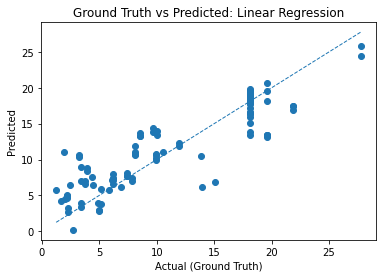

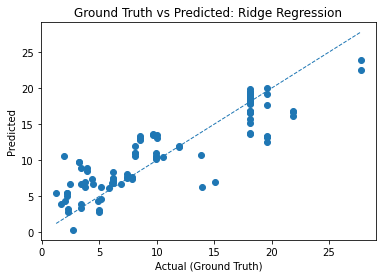

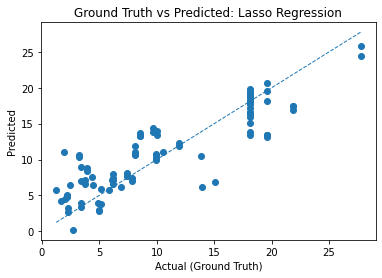

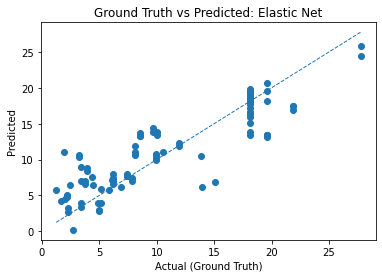

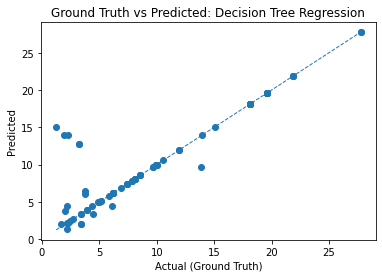

In [36]:
models_ = [LinearRegression(),Ridge(),Lasso(alpha=0.0001),ElasticNet(alpha=0.0001),DecisionTreeRegressor()]
scaled_df = select_feature('INDUS')
scaled_df.head()
df_comb_INDUS = run_model_set(True,False)
df_comb_INDUS

For easier viewing than just graphs, lets look at the tables for INDUS and NOX (remember we further tuned NOX)

In [37]:
df_comb_INDUS

,Model,R2_train,R2_val,R2_test,mse_train,mse_val,mse_test
0,Linear Regression,0.740936,0.767011,0.785859,1.221381e+01,10.803310,10.202123
1,Ridge Regression,0.738039,0.766521,0.784899,1.235036e+01,10.826055,10.247881
2,Lasso Regression,0.740936,0.767036,0.785881,1.221382e+01,10.802143,10.201103
3,Elastic Net,0.740934,0.767103,0.785948,1.221391e+01,10.799050,10.197886
4,Decision Tree Regression,1.000000,0.863856,0.855639,2.059472e-28,6.312759,6.877647


In [38]:
df_comb_NOX

,Model,R2_train,R2_val,R2_test,mse_train,mse_val,mse_test
0,Linear Regression,0.788862,0.746665,0.749260,2.923424e-03,0.003057,0.003119
1,Ridge Regression,0.786711,0.751592,0.753896,2.953210e-03,0.002998,0.003061
2,Lasso Regression,0.788177,0.752023,0.753894,2.932912e-03,0.002993,0.003061
3,Elastic Net,0.788636,0.749836,0.752207,2.926549e-03,0.003019,0.003082
4,Decision Tree Regression,1.000000,0.832086,0.826878,5.984103e-33,0.002027,0.002153


Above we have our two different features from the above that we worked on predicting. In both situations decision tree regression results in the highest R2 (and lowest MSE). With the other regression models (linear, ridge, lasso) all performing relatively similar, elastic net included. Remember, we even reduced alpha in lasso and elastic net, so it penalization system is not that influential. In all situations we see that the training sets fit better than the validation sets, but we are noticing similar performance between the validation and test sets. There is some minor overfitting occuring, but it's not significant. Keep in mind the MSE values between the INDUX and NOX dataset will be different, this also has to to do with the range of values INDUS and NOX can be. I do not believe we can directly compare MSE between two different target variables, unless we are comparing how well fitted we are to our linear regression line. 

### **Lets do a few extra for fun!**

###### Another Feature: RAD

In [39]:
scaled_df = select_feature('RAD')
scaled_df.head()
df_comb_RAD= run_model_set(False,True)
df_comb_RAD

,Model,R2_train,R2_val,R2_test,mse_train,mse_val,mse_test
0,Linear Regression,0.882300,0.834333,0.826790,8.955925,12.324431,13.432372
1,Ridge Regression,0.879906,0.831426,0.822252,9.138069,12.540621,13.784350
2,Lasso Regression,0.719196,0.673434,0.659752,21.366649,24.294076,26.386159
3,Elastic Net,0.291975,0.283956,0.271510,53.874369,53.268361,56.494239
4,Decision Tree Regression,1.000000,0.995131,0.994311,0.000000,0.362205,0.441176


Let's adjust regularization strength here as well (notice the high MSE for elasticnet and lasso regresion). We will notice an improvement (below). Incredibly our ability with Decision Tree Regression allows us to obtain an R2 of 0.99, which is significantly higher than all other models. 

,Model,R2_train,R2_val,R2_test,mse_train,mse_val,mse_test
0,Linear Regression,0.882300,0.834333,0.826790,8.955925,12.324431,13.432372
1,Ridge Regression,0.879906,0.831426,0.822252,9.138069,12.540621,13.784350
2,Lasso Regression,0.882300,0.834321,0.826781,8.955938,12.325259,13.433115
3,Elastic Net,0.882298,0.834305,0.826732,8.956054,12.326456,13.436917
4,Decision Tree Regression,1.000000,0.994708,0.993679,0.000000,0.393701,0.490196


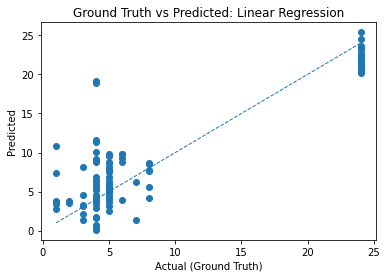

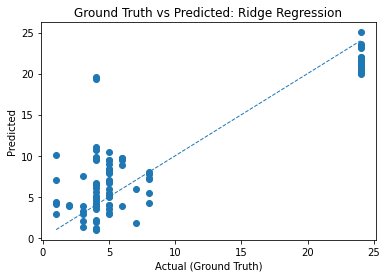

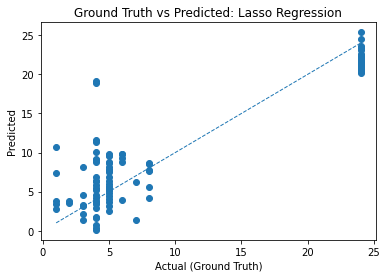

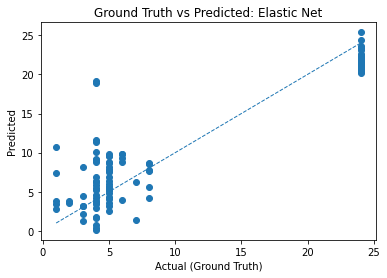

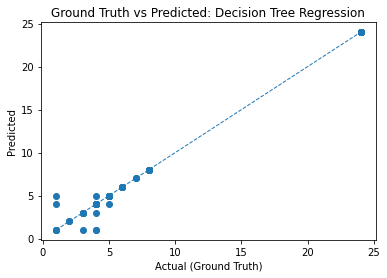

In [40]:
models_ = [LinearRegression(),Ridge(),Lasso(alpha=0.0001),ElasticNet(alpha=0.0001),DecisionTreeRegressor()]
scaled_df = select_feature('RAD')
scaled_df.head()
df_comb_RAD= run_model_set(True,False)
df_comb_RAD

###### Another Feature: TAX

In [41]:
scaled_df = select_feature('TAX')
scaled_df.head()
df_comb_TAX= run_model_set(False,True)
df_comb_TAX

,Model,R2_train,R2_val,R2_test,mse_train,mse_val,mse_test
0,Linear Regression,0.901258,0.851969,0.845316,2828.854158,4047.389161,4216.610446
1,Ridge Regression,0.900496,0.852349,0.845951,2850.669596,4037.010327,4199.291018
2,Lasso Regression,0.895249,0.852818,0.844351,3000.996612,4024.172122,4242.907204
3,Elastic Net,0.501959,0.499141,0.485065,14268.339081,13694.232845,14036.863279
4,Decision Tree Regression,1.000000,0.929513,0.937342,0.000000,1927.220472,1708.039216


We can see here again, that we would need to adjust regularization strength for elastic net. Once we do, we observe that decision tree regression again outperforms all other models. However, we also notice (much like before) that the decision tree very tightly fits our training data with a MSE of 0 and therefore also a training set R2 of 1. However, even with this very tight fit (perfect fit), we are still observing higher prediction accuracy than any other model. Note how elastic net is having performance issues. Let's only modify elasticnet's alpha (down) to compensate for the penalty on the weights being too big.  

,Model,R2_train,R2_val,R2_test,mse_train,mse_val,mse_test
0,Linear Regression,0.901258,0.851969,0.845316,2828.854158,4047.389161,4216.610446
1,Ridge Regression,0.900496,0.852349,0.845951,2850.669596,4037.010327,4199.291018
2,Lasso Regression,0.895249,0.852818,0.844351,3000.996612,4024.172122,4242.907204
3,Elastic Net,0.901257,0.851991,0.845347,2828.867249,4046.781197,4215.774199
4,Decision Tree Regression,1.000000,0.929755,0.932028,0.000000,1920.590551,1852.882353


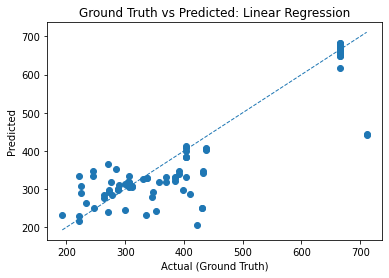

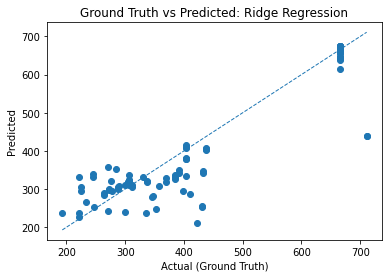

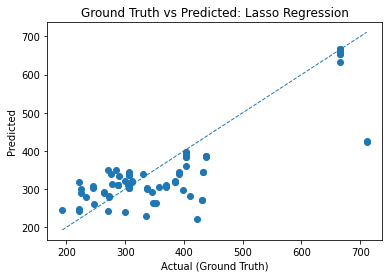

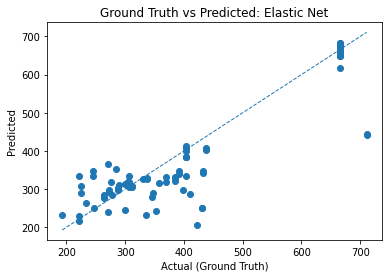

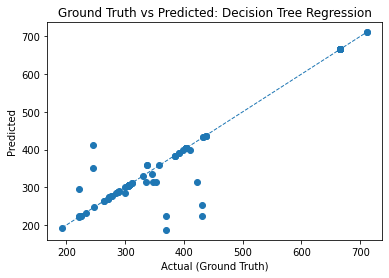

In [42]:
models_ = [LinearRegression(),Ridge(),Lasso(),ElasticNet(alpha=0.0001),DecisionTreeRegressor()]
scaled_df = select_feature('TAX')
scaled_df.head()
df_comb_TAX= run_model_set(True,False)
df_comb_TAX

### Further Discussion on each method

While we quantified the performance above and started a discussion on each method it behooves us to take a further dive. 

###### Linear Regression Method Family

In our standard linear regression model we are not penalizing the model for weight choices. This can result in overfitting in smaller datasets. It's not well observed in our dataset, but the standard linear regression model has a slightly (very slight) difference between training/validation and test accuracy. While there is multicollinearity in our selected training data (feature sets and predictions) it is not exceptionally high, so we do not notice how linear regression (traditional) may underperform in that situation in as dramatic of a fashion that it could have been. We do observe some independent variables approaching high correlation, such as TAX and RAD, but that pairing was one of the only highly linear ones. We selected both TAX and RAD as a predicted value, and did not observe and significant differences between linear,lasso,ridge, and elastic net. 

The lasso regression model we ran has a penalization system based on the sum of the absolute values of the weights. This can cause the absolute values of certain weights to be reduced (approaching zero) - driving sparse solutions. You can see how we modified the new hyper parameter (alpha) to modify the coefficient that penalizes weights.

The ridge regression model, is similar to the lasso regression model, except we now penalize the model based on the sum of squared values of the weights instead of absolute. This results in us penalizing the extremes of the weights more, and should imply more even distribution of weights. Does drive weights down to zero but 'weakens' them. This creates stability improvements. Again, we do not really observe this due to multicollinearity being present but not too high. 

Elastic Net is an interesting hybdrid between lasso and ridge (elastic includes L1 and L2 regularization). We performed normalization before training our models so the default (normalize=false) is okay. standard linear, lasso regression, ridge regression, and elastic net will have similarities in performance, since the differences are in the penalization system used. However, for this dataset, as mentioned, we have relatively 'clean' data with low multicollinearity. As such we will not observe significant differences between the models. We also pre-emptively analyzed correlations between features and selected features to use for training purposes. Also, since we not facing non-linear solutions we are not seeing some of the shortcomings of the regression models used here (cannot build positive-definite matrices using PDS kernels). Kernel Ridge Regression from the Week 8 readings could be a solution for this (alongside the decision tree regression model). 

As a general point, in the event we have very high multicollinearity I would have expected to see noticeable performance differences between standard linear vs lasso,ridge,elastic net. With the latter outperforming prediction accuracy compared to standard linear regression.

###### Decision Tree Method Family

Decision trees are quite robust against outliers (as we can see from our graphing there are quite a few depending on the feature set). While for the most part our dataset is relatively linear, whenever we are dealing with non-linearity, the decision tree regression model will outperform traditional linear regression models. Furthermore, in this dataset we are not dealign with a large number of features with more data-sets, in this case we have a low number of features and a relatively low number of data-set (samples). We do not really have any categorical independent variables, which a decision tree would perform well on - though we can perform pre-processing on the data such as combining label encoding and one-hot encoding to enable linear regression models to still 'work'. 

Our decision tree regression model can handle colinearity better, which we see demonstrated. While we saw some correlations between features, there really is one may high correlation, there were other features that were also correlated but not p>.90, which was only TAX and RAD.